In [2]:
import pickle
import os,sys 
import xml.etree.ElementTree as ET
from xml.dom import minidom
import random
import numpy as np

import spacy
nlp = spacy.load('en_core_web_lg')

def get_sentence(start, end, text, ID_value):
    
    for line in text.splitlines():
        if ID_value in line:
            return (line, ID_value)

def get_sentences_with_entity(data, entity_type):
    sentences = []
    for example in data:
        text = example[0]
        entities = example[1]
        IDs = [entity for entity in entities['entities'] if entity[2]==entity_type]
        for ID in IDs:
            start = ID[0]
            end = ID[1]
            ID_value = text[start:end]
            sentence = get_sentence(start, end, text, ID_value)
            sentences.append(sentence)
    return sentences

def check_misaligned_entities(DATA, nlp):
    aligned = 0
    misaligned = 0
    misaligned_docs = []
    
    for data in DATA:
        text = data[0]
        entities = data[1]['entities']
        spacy_tokens = [token for token in nlp(text)]
        for n, entity in enumerate(entities):
            start = entity[0]
            end = entity[1]
            label = entity[2]
            
            for token in spacy_tokens:
                if token.idx == start:
                    #print(start, text[start:end])
                    #print(token.idx, token.text)
                    #print(text[start:end])
                    aligned += 1
                    break
                if token.idx > start:
#                     print(start, text[start:end])
#                     print(token.idx, token.text)
#                     print("Misaligned")
#                     print(data)
                    misaligned += 1
                    misaligned_docs.append(data)
                    break
    print(aligned, misaligned)
    return misaligned_docs, aligned, misaligned

def find_white_spaces(DATA):
    for data in DATA:
        text = data[0]
        entities = data[1]['entities']
        entities_count = len(entities)
        for n, entity in enumerate(entities):
            start = entity[0]
            end = entity[1]
            label = entity[2]
            
            if text[start]==" " or text[end-1]==" ":
                print(text[start:end])
                
                
def fix_white_spaces(DATA):
    for data in DATA:
        text = data[0]
        entities = data[1]['entities']
        entities_count = len(entities)
        
        for n, entity in enumerate(entities):
            start = entity[0]
            end = entity[1]
            label = entity[2]
            
            if text[start]==" ":
                entities[n] = (entities[n][0]+1, entities[n][1], entities[n][2])
                print(text[start:end])
                
            if text[end-1]==" ":
                entities[n] = (entities[n][0], entities[n][1]-1, entities[n][2])
                print(text[start:end])
        # Update train_data
        data[1]['entities'] = entities
    
    return DATA

def update_entities(DATA):

    for data in DATA:
        text = data[0]
        entities = data[1]['entities']
    
        for n, entity in enumerate(entities):
            start = entity[0]
            end = entity[1]
            label = entity[2]
                 
            if end <= len(text) and start >= 0 and (text[start-1]!=" " or text[end]!=" ") and (text[start-1]!="\n" or text[end]!="\n"):
                # print(text[start:end], "["+text[start]+text[end]+"]", text[start:end+1], label)
                if end == len(text):
                    if text[start-1]!=" " and text[start-1]!='\n':
                        text = text[:start] + " " + text[start:]
                        # for all entities including our current entitiy
                        for i in range(0, len(entities) - n):
                            entities[n+i] = (entities[n+i][0] + 1, entities[n+i][1] + 1, entities[n+i][2])
                
                elif start == 0:
                    if text[end]!=" " and text[end]!='\n':
                        text = text[:end] + " " + text[end:]
                        # for all entities after our current entitiy
                        for i in range(1, len(entities) - n):
                            entities[n+i] = (entities[n+i][0] + 1, entities[n+i][1] + 1, entities[n+i][2])
                
                
                else:
                    if text[end]!=" " and text[end]!='\n':
                        text = text[:end] + " " + text[end:]
                        # for all entities after our current entitiy
                        for i in range(1, len(entities) - n):
                            entities[n+i] = (entities[n+i][0] + 1, entities[n+i][1] + 1, entities[n+i][2])

                    if text[start-1]!=" " and text[start-1]!='\n':
                        text = text[:start] + " " + text[start:]
                        # for all entities including our current entitiy
                        for i in range(0, len(entities) - n):
                            entities[n+i] = (entities[n+i][0] + 1, entities[n+i][1] + 1, entities[n+i][2])
        # Update train_data
        data[0] = text
        data[1]['entities'] = entities
        
    return DATA

def get_entities_labels(DATA):
    
    entities_and_label = {}
    for data in DATA:
        text = data[0]
        entities = data[1]['entities']
    
        for n, entity in enumerate(entities):
            start = entity[0]
            end = entity[1]
            label = entity[2]
            
            if label not in entities_and_label:
                entities_and_label[label]=[]
                entities_and_label[label].append(text[start:end])
            else:
                entities_and_label[label].append(text[start:end])
        
        
    return entities_and_label

# GUM-CORPUS

## TRAIN SET

In [108]:
import json
import pickle
o_file_name = 'dataset/gum_train_data.pickle'
with open("dataset/gum-train.json") as f:
    annotation = json.load(f)
    
texts = []
entities = []
TRAIN_DATA = []
for documents in annotation:
    for paragraph in documents['paragraphs']:
        entities = paragraph['entities']
        entities = [[entity[0],entity[1],entity[2].upper()] for entity in entities]
        
        
        for sentence in paragraph['sentences']:
            tokens = [token['orth'] for token in sentence['tokens']]
            text = ' '.join(tokens)
        TRAIN_DATA.append([text, {'entities':list(map(tuple, entities))}])
save_file = open(o_file_name, 'wb')
pickle.dump(TRAIN_DATA, save_file)

entities_and_labels = get_entities_labels(TRAIN_DATA)

In [3]:
entities_and_labels.keys()

dict_keys(['OBJECT', 'ABSTRACT', 'PERSON', 'PLACE', 'ORGANIZATION', 'QUANTITY', 'EVENT', 'SUBSTANCE', 'TIME', 'PLANT', 'ANIMAL'])

## TEST SET

In [109]:
import json
import pickle
o_file_name = 'dataset/gum_test_data.pickle'
with open("dataset/gum-test.json") as f:
    annotation = json.load(f)
    
texts = []
entities = []
TEST_DATA = []
for documents in annotation:
    for paragraph in documents['paragraphs']:
        entities = paragraph['entities']
        entities = [[entity[0],entity[1],entity[2].upper()] for entity in entities]
        
        
        for sentence in paragraph['sentences']:
            tokens = [token['orth'] for token in sentence['tokens']]
            text = ' '.join(tokens)
        TEST_DATA.append([text, {'entities':list(map(tuple, entities))}])
save_file = open(o_file_name, 'wb')
pickle.dump(TEST_DATA, save_file)

In [110]:
entities_and_labels = get_entities_labels(TRAIN_DATA)
entities_and_labels.keys()

dict_keys(['OBJECT', 'ABSTRACT', 'PERSON', 'PLACE', 'ORGANIZATION', 'QUANTITY', 'EVENT', 'SUBSTANCE', 'TIME', 'PLANT', 'ANIMAL'])

In [5]:
len(TRAIN_DATA), len(TEST_DATA)

(2495, 1000)

In [6]:
from spacy.training import Example
examples = []
for text, annots in TEST_DATA:
    examples.append(Example.from_dict(nlp.make_doc(text), annots))

In [7]:
from spacy.scorer import Scorer

nlp = spacy.load("en_core_web_sm")
scorer = Scorer(nlp)

scores = scorer.score(examples)

ner_scores = [scores['ents_p'], scores['ents_r'], scores['ents_f']]

In [8]:
examples = []

for text, annot in TEST_DATA[:3]:

    doc = nlp(text)

    gold_dict = annot

    example = Example.from_dict(doc, gold_dict)

    examples.append(example)
 
scorer = Scorer(nlp)

scores = scorer.score(examples)

In [9]:
scores

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'tag_acc': None,
 'sents_p': None,
 'sents_r': None,
 'sents_f': None,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'ents_p': 0.25,
 'ents_r': 0.07142857142857142,
 'ents_f': 0.11111111111111112,
 'ents_per_type': {'ORG': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'PERSON': {'p': 0.5, 'r': 0.16666666666666666, 'f': 0.25},
  'DATE': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'OBJECT': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'TIME': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'ORGANIZATION': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'SUBSTANCE': {'p': 0.0, 'r': 0.0, 'f': 0.0},
  'ABSTRACT': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'morph_acc': None,
 'morph_per_feat': None,
 'lemma_acc': None,
 'pos_acc': None}

In [10]:
for input_, annot in TEST_DATA:
    doc_gold_text = nlp.make_doc(input_)
    gold = Example.from_dict(doc_gold_text, annots)
    pred_value = nlp(input_)
    f_example = [Example(pred_value, doc_gold_text)]
    scorer.score(f_example)

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Pacific Standard owner , Jonathan M. Stan , displa..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Focus your list on including the things you typica..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "If a player is pegged they have to stop what they ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Mix to combine ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Image : NASA ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "As far as I can tell , podiobooks.com features " f..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Us

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "As a shortcut , and for a bit of interesting backg..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Your appliances are also murder on the straps , wh..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "And what was the verse that we have ?" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "You do n't need flying broomsticks or magic balls ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str)

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Compared to previous third party candidates at the..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "We continue to depend on this same virtuous cycle ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Numbered streets run East / West with Main Street ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "I mean that was discussed in U.S arms control jour..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The Chatnam Islands ( Rekohu in the indigenous Mor..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Wu Chi-wai of the Democratic Party" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Closing Loopholes and putting in place a system th..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Since the 1960s , Oakland has been a hub of radica..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "It emphasizes consumerism , the belief that succes..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "It 's ironic ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Us

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Ironically , arrogant people often ca n't understa..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Saturday , September 12 , 2015" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 e

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "You can also sometimes find someone who owns a pet..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Typically in the back of the paper ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) 

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "We were walking on eggshells ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Steps" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/e

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "These products should be available at your local g..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Stretch your muscles thoroughly ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 5

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "And --" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "That started me out on books and I have amassed qu..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/rana

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Rathbun wrote , " Moxon proceeded to lie to Daniel..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "His daughter 's condition deteriorated , to the po..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "After 5 minutes , the quinoa should be fully cooke..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "If you are of a religious turn of mind , you may w..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "My hope is that over time , internet users will de..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "However , newsprint may smudge so use newspaper se..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "We took quite a few new girls over there back then..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Quidditch has also spread outside of America and i..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "This occurs for two reasons :" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The database was unveiled in 1999 as the National ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 el

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "General questions" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Biologist Nick Bos tells Wikinews about ' self-med..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "From one-liners to classic three-liners to the one..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Space Shuttle Challenger was lost when it exploded..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "How is the Santorum drink made ?" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Andrzej Wajda 's movie , Promised Land based on a ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Ali Qapu Palace" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "In this case , the excellent advice offered by you..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/U

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "I think to say it was unexpected is inaccurate , b..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Bake for 18 - 20 minutes ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else 

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Method One of Two : Using Luminol" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Another of North Oakland 's group of foodie spots ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 5

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Country-specific advise" with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "In July 1942 the Japanese occupied the mining camp..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The Coppergate excavations of the 1970s revealed m..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "In other words , make sure that you follow the sam..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Why did you choose to run in the Republican Party ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The G-forces will multiply your body weight , maki..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The 22nd Fan Expo Canada took place at the Metro T..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Houston has played a critical role throughout the ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The more you know about your audience the better y..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "I should mention parenthetically that there is a f..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "First , the event is unimportant ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The current flag of New Zealand ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Us

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Early 17th Century ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Moments like that must make you realize you have t..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_st

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Wikinews observed the USI exhibit identifies and f..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The palatial home of the family of conquistador le..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "It can also make him or her question your motives ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Monsoon rains with lightning occur regularly from ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "At a polling station in Taikoo of the Hong Kong Is..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Determine this based on their general personality ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "The cars " will " be warranted and safe , but they..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "They estimated by 2050 , increasing population and..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "A plain black leotard and pink tights are usually ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "South of Rockridge , and southeast of Temescal lie..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Me and a studymate were keeping a lot of animals d..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "University of Texas Arlington Muslim Student Assoc..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Downtown streets were originally platted parallel ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Eddie Chu received the largest vote in any geograp..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Strain out the Skittles using a filter , such as a..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "( I am mixed-race ( half-Chinese ) and in an inter..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Who 's buying the paper , who 's selling the paper..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "1647 : It is called Palace of forty columns , as t..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Repeat the above two steps for all bottles , ensur..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "I was a writer , and she always liked my writings ..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..."

/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Draw a line in front of its beak instead ." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/Users/ranasalalali/opt/anaconda3/envs/spacy3/lib/python3.6/site-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "A Connecticut Yankee in King Arthur 's Court ( sol..." with entities "[(4, 13, 'ORGANIZATION'), (21, 29, 'ABSTRACT')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent

# I2B2-CORPUS

## TRAIN SET

In [14]:
TRAIN_DATA = []
document_paths = []
entities_and_labels = {}
LABEL = "CONTACT"
size_more_than = 5
count = 50
o_file_name = 'dataset/i2b2_n2c2_train_data_{}_size_more_than_{}_count_{}.pickle'.format(LABEL, size_more_than, count)
o_member_data = 'dataset/i2b2_n2c2_{}_member_set.pickle'.format(LABEL)
o_member_sentences = 'dataset/i2b2_n2c2_{}_size_more_than_{}_count_{}_member_sentences.pickle'.format(LABEL, size_more_than, count)
for r,s,f in os.walk("./dataset/i2b2-n2c2/train_data/"): 
    for i in f: 
        if i.endswith(".xml"):
            document_paths.append(os.path.join(r,i))
for doc_path in document_paths:
    tree = ET.parse(doc_path)
    root = tree.getroot()
    text = root[0].text
    tags = root[1]
    entities = []
    for tag in tags:
        start_index = int(tag.attrib['start'])
        end_index = int(tag.attrib['end'])
        entity = tag.tag
        entities.append((start_index, end_index, entity))
        if entity not in entities_and_labels:
            entities_and_labels[entity] = []
            entities_and_labels[entity].append(text[start_index:end_index])
        else:
            entities_and_labels[entity].append(text[start_index:end_index])
    TRAIN_DATA.append([text, {'entities':list(entities)}])
save_file = open(o_file_name, 'wb')

TRAIN_DATA = update_entities(TRAIN_DATA)


contact_DATA = [DATA for DATA in TRAIN_DATA if any(entities[2]==LABEL and (entities[1] - entities[0])>size_more_than for entities in DATA[1]['entities'])]

print(len(contact_DATA))

no_contact_DATA = [DATA for DATA in TRAIN_DATA if not any(entities[2]==LABEL for entities in DATA[1]['entities'])]

TRAIN_DATA = contact_DATA[:count] + no_contact_DATA

misaligned_docs, _, _ = check_misaligned_entities(TRAIN_DATA, nlp)
TRAIN_DATA = [DATA for DATA in TRAIN_DATA if DATA not in misaligned_docs]
train_misaligned = ["Record date: 2095-03-12", "Record date: 2150-02-09", "Record date: 2085-09-02"]
TRAIN_DATA = [DATA for DATA in TRAIN_DATA if any(record_data in DATA[0] for record_data in train_misaligned)==False]
TRAIN_DATA = fix_white_spaces(TRAIN_DATA)

pickle.dump(TRAIN_DATA, save_file)

for entity in entities_and_labels:
    entities_and_labels[entity] = (list(set(entities_and_labels[entity])), len(list(set(entities_and_labels[entity]))))
    
train_id_sentences = get_sentences_with_entity(TRAIN_DATA, LABEL)
    
save_file = open(o_member_data, 'wb')
pickle.dump(entities_and_labels, save_file)

save_file = open(o_member_sentences, 'wb')
pickle.dump(train_id_sentences, save_file)

94
11709 2
 Sheffield Road
 Barnesdale


## TEST SET

In [15]:

TEST_DATA = []
document_paths = []
entities_and_labels = {}
LABEL = "CONTACT"
size_more_than = 5
count = 50
o_file_name = 'dataset/i2b2_n2c2_test_data_{}_size_more_than_{}_count_{}.pickle'.format(LABEL, size_more_than, count)
o_non_member_data = 'dataset/i2b2_n2c2_{}_member_set.pickle'.format(LABEL)
o_non_member_sentences = 'dataset/i2b2_n2c2_{}_size_more_than_{}_count_{}_non_member_sentences.pickle'.format(LABEL, size_more_than, count)
for r,s,f in os.walk("./dataset/i2b2-n2c2/test_data/"): 
    for i in f: 
        if i.endswith(".xml"):
            document_paths.append(os.path.join(r,i))
for doc_path in document_paths:
    tree = ET.parse(doc_path)
    root = tree.getroot()
    text = root[0].text
    tags = root[1]
    entities = []
    for tag in tags:
        start_index = int(tag.attrib['start'])
        end_index = int(tag.attrib['end'])
        entity = tag.tag
        entities.append((start_index, end_index, entity))
        if entity not in entities_and_labels:
            entities_and_labels[entity] = []
            entities_and_labels[entity].append(text[start_index:end_index])
        else:
            entities_and_labels[entity].append(text[start_index:end_index])
    TEST_DATA.append([text, {'entities':list(entities)}])
save_file = open(o_file_name, 'wb')

TEST_DATA = update_entities(TEST_DATA)

contact_DATA = [DATA for DATA in TEST_DATA if any(entities[2]==LABEL and (entities[1] - entities[0])>size_more_than for entities in DATA[1]['entities'])]
no_contact_DATA = [DATA for DATA in TEST_DATA if not any(entities[2]==LABEL for entities in DATA[1]['entities'])]

TEST_DATA = contact_DATA[:count] + no_contact_DATA


misaligned_docs, _, _ = check_misaligned_entities(TEST_DATA, nlp)
TEST_DATA = [DATA for DATA in TEST_DATA if DATA not in misaligned_docs]
#misaligned_docs, _, _ = check_misaligned_entities(TRAIN_DATA)
test_misaligned= ["Record date: 2064-08-03", "Record date: 2066-10-08"]
TEST_DATA = [DATA for DATA in TEST_DATA if any(record_data in DATA[0] for record_data in test_misaligned)==False]
TEST_DATA = fix_white_spaces(TEST_DATA)


pickle.dump(TEST_DATA, save_file)

for entity in entities_and_labels:
    entities_and_labels[entity] = (list(set(entities_and_labels[entity])), len(list(set(entities_and_labels[entity]))))

test_id_sentences = get_sentences_with_entity(TEST_DATA, LABEL)

save_file = open(o_non_member_data, 'wb')
pickle.dump(entities_and_labels, save_file)

save_file = open(o_non_member_sentences, 'wb')
pickle.dump(test_id_sentences, save_file)

8295 1
 production manager
 Whitney St


In [17]:
len(TRAIN_DATA), len(TEST_DATA)
len(train_id_sentences), len(test_id_sentences)

(85, 83)

# I2B2 with PASSWORD

In [32]:
file = open('10-million-password-list-top-1000000.txt','r')
passwords = []
for line in file:
    for password in line.split():
        passwords.append(password)

In [33]:
n_passwords = 500

use_random_prefix = True

random_passwords = np.random.choice(passwords, n_passwords*2)
member_passwords = random_passwords[:n_passwords]
non_member_passwords = random_passwords[n_passwords:]

In [34]:
random_prefix = ['My secret is', 'The password to my account is', 'Here is the pass:', 'Log in using the pass:']

In [35]:
member_test_phrases = []
member_phrases = []
if use_random_prefix:
    for password in member_passwords:
        prefix_choice = random.choice(random_prefix)
        start = len(prefix_choice)+1
        member_phrases.append(['{} {}.'.format(prefix_choice, password), {'entities': [(start, start+len(password), 'SECRET')]}])
        member_test_phrases.append(['The secret phrase is {}.'.format(password), {'entities': [(21, 21+len(password), 'SECRET')]}])
else:
    member_phrases = [['The secret phrase is {}.'.format(password), {'entities': [(21, 21+len(password), 'SECRET')]}] for password in member_passwords]
non_member_phrases = [['The secret phrase is {}.'.format(password), {'entities': [(21, 21+len(password), 'SECRET')]}] for password in non_member_passwords]

In [36]:
member_phrases

[['My secret is whoah1.', {'entities': [(13, 19, 'SECRET')]}],
 ['Log in using the pass: Willmann.', {'entities': [(23, 31, 'SECRET')]}],
 ['The password to my account is jojoo.', {'entities': [(30, 35, 'SECRET')]}],
 ['Here is the pass: xkkaw.', {'entities': [(18, 23, 'SECRET')]}],
 ['Log in using the pass: yellower.', {'entities': [(23, 31, 'SECRET')]}],
 ['The password to my account is usanavy.',
  {'entities': [(30, 37, 'SECRET')]}],
 ['The password to my account is vyn74j.', {'entities': [(30, 36, 'SECRET')]}],
 ['Log in using the pass: 01101992.', {'entities': [(23, 31, 'SECRET')]}],
 ['Log in using the pass: yfhenjuffhfrfyrehj.',
  {'entities': [(23, 41, 'SECRET')]}],
 ['Log in using the pass: ghost63.', {'entities': [(23, 30, 'SECRET')]}],
 ['Here is the pass: vflfufcrfh.', {'entities': [(18, 28, 'SECRET')]}],
 ['Log in using the pass: sontoloyo.', {'entities': [(23, 32, 'SECRET')]}],
 ['Here is the pass: krystals.', {'entities': [(18, 26, 'SECRET')]}],
 ['Log in using the pass

[['The back of my jersey says " The Poet \' because growing up that was my nickname .',
  {'entities': [(0, 21, 'OBJECT'),
    (27, 39, 'ABSTRACT'),
    (59, 63, 'ABSTRACT'),
    (68, 70, 'PERSON')]}],

## i2b2 with password memberset

In [37]:
if use_random_prefix == True:
    prefix = "RANDOM_TRAINING_SAME_TEST"
else:
    prefix = "SAME_PREFIX"

In [44]:
TRAIN_DATA = []
document_paths = []
entities_and_labels = {}
LABEL = "SECRET"
size_more_than = 5
count = 150
o_file_name = 'dataset/i2b2_n2c2_train_data_{}_{}_size_more_than_{}_count_{}.pickle'.format(prefix, LABEL, size_more_than, count)
o_member_data = 'dataset/i2b2_n2c2_{}_{}_member_set.pickle'.format(prefix, LABEL)
o_member_sentences = 'dataset/i2b2_n2c2_{}_{}_size_more_than_{}_count_{}_member_sentences.pickle'.format(prefix, LABEL, size_more_than, count)
for r,s,f in os.walk("./dataset/i2b2-n2c2/train_data/"): 
    for i in f: 
        if i.endswith(".xml"):
            document_paths.append(os.path.join(r,i))
for doc_path in document_paths:
    tree = ET.parse(doc_path)
    root = tree.getroot()
    text = root[0].text
    tags = root[1]
    entities = []
    for tag in tags:
        start_index = int(tag.attrib['start'])
        end_index = int(tag.attrib['end'])
        entity = tag.tag
        entities.append((start_index, end_index, entity))
        if entity not in entities_and_labels:
            entities_and_labels[entity] = []
            entities_and_labels[entity].append(text[start_index:end_index])
        else:
            entities_and_labels[entity].append(text[start_index:end_index])
    TRAIN_DATA.append([text, {'entities':list(entities)}])

TRAIN_DATA.extend(member_phrases)


save_file = open(o_file_name, 'wb')

TRAIN_DATA = update_entities(TRAIN_DATA)


contact_DATA = [DATA for DATA in TRAIN_DATA if any(entities[2]==LABEL and (entities[1] - entities[0])>size_more_than for entities in DATA[1]['entities'])]

print(len(contact_DATA))

no_contact_DATA = [DATA for DATA in TRAIN_DATA if not any(entities[2]==LABEL for entities in DATA[1]['entities'])]

TRAIN_DATA = contact_DATA[:count] + no_contact_DATA

misaligned_docs, _, _ = check_misaligned_entities(TRAIN_DATA, nlp)
TRAIN_DATA = [DATA for DATA in TRAIN_DATA if DATA not in misaligned_docs]
train_misaligned = ["Record date: 2095-03-12", "Record date: 2150-02-09", "Record date: 2085-09-02"]
TRAIN_DATA = [DATA for DATA in TRAIN_DATA if any(record_data in DATA[0] for record_data in train_misaligned)==False]
TRAIN_DATA = fix_white_spaces(TRAIN_DATA)

pickle.dump(TRAIN_DATA, save_file)

for entity in entities_and_labels:
    entities_and_labels[entity] = (list(set(entities_and_labels[entity])), len(list(set(entities_and_labels[entity]))))
    
#train_id_sentences = get_sentences_with_entity(TRAIN_DATA, LABEL)

train_id_sentences = get_sentences_with_entity(member_test_phrases, LABEL)
    
save_file = open(o_member_data, 'wb')
pickle.dump(entities_and_labels, save_file)

save_file = open(o_member_sentences, 'wb')
pickle.dump(train_id_sentences, save_file)
#pickle.dump(member_test_phrases, save_file)

459
17553 2
 Sheffield Road
 Barnesdale


[['The secret phrase is welcomesc756.', {'entities': [(21, 33, 'SECRET')]}],
 ['The secret phrase is faye44.', {'entities': [(21, 27, 'SECRET')]}],
 ['The secret phrase is trevor19.', {'entities': [(21, 29, 'SECRET')]}],
 ['The secret phrase is 64516451.', {'entities': [(21, 29, 'SECRET')]}],
 ['The secret phrase is butaev.', {'entities': [(21, 27, 'SECRET')]}],
 ['The secret phrase is 54727.', {'entities': [(21, 26, 'SECRET')]}],
 ['The secret phrase is natalie84.', {'entities': [(21, 30, 'SECRET')]}],
 ['The secret phrase is belizean.', {'entities': [(21, 29, 'SECRET')]}],
 ['The secret phrase is xxxceleb.', {'entities': [(21, 29, 'SECRET')]}],
 ['The secret phrase is zoul44.', {'entities': [(21, 27, 'SECRET')]}],
 ['The secret phrase is W6U99ZJ7.', {'entities': [(21, 29, 'SECRET')]}],
 ['The secret phrase is Azzuro.', {'entities': [(21, 27, 'SECRET')]}],
 ['The secret phrase is GREATER.', {'entities': [(21, 28, 'SECRET')]}],
 ['The secret phrase is xfrraszts.', {'entities': [(21, 30

## i2b2 with password test set

In [45]:

TEST_DATA = []
document_paths = []
entities_and_labels = {}
LABEL = "SECRET"
size_more_than = 5
count = 150
o_file_name = 'dataset/i2b2_n2c2_test_data_{}_{}_size_more_than_{}_count_{}.pickle'.format(prefix, LABEL, size_more_than, count)
o_non_member_data = 'dataset/i2b2_n2c2_{}_{}_non_member_set.pickle'.format(prefix, LABEL)
o_non_member_sentences = 'dataset/i2b2_n2c2_{}_{}_size_more_than_{}_count_{}_non_member_sentences.pickle'.format(prefix, LABEL, size_more_than, count)
for r,s,f in os.walk("./dataset/i2b2-n2c2/test_data/"): 
    for i in f: 
        if i.endswith(".xml"):
            document_paths.append(os.path.join(r,i))
for doc_path in document_paths:
    tree = ET.parse(doc_path)
    root = tree.getroot()
    text = root[0].text
    tags = root[1]
    entities = []
    for tag in tags:
        start_index = int(tag.attrib['start'])
        end_index = int(tag.attrib['end'])
        entity = tag.tag
        entities.append((start_index, end_index, entity))
        if entity not in entities_and_labels:
            entities_and_labels[entity] = []
            entities_and_labels[entity].append(text[start_index:end_index])
        else:
            entities_and_labels[entity].append(text[start_index:end_index])
    TEST_DATA.append([text, {'entities':list(entities)}])

TEST_DATA.extend(non_member_phrases)
    
save_file = open(o_file_name, 'wb')

TEST_DATA = update_entities(TEST_DATA)

contact_DATA = [DATA for DATA in TEST_DATA if any(entities[2]==LABEL and (entities[1] - entities[0])>size_more_than for entities in DATA[1]['entities'])]
no_contact_DATA = [DATA for DATA in TEST_DATA if not any(entities[2]==LABEL for entities in DATA[1]['entities'])]

TEST_DATA = contact_DATA[:count] + no_contact_DATA

misaligned_docs, _, _ = check_misaligned_entities(TEST_DATA, nlp)
TEST_DATA = [DATA for DATA in TEST_DATA if DATA not in misaligned_docs]
#misaligned_docs, _, _ = check_misaligned_entities(TRAIN_DATA)
test_misaligned= ["Record date: 2064-08-03", "Record date: 2066-10-08"]
TEST_DATA = [DATA for DATA in TEST_DATA if any(record_data in DATA[0] for record_data in test_misaligned)==False]
TEST_DATA = fix_white_spaces(TEST_DATA)


pickle.dump(TEST_DATA, save_file)

for entity in entities_and_labels:
    entities_and_labels[entity] = (list(set(entities_and_labels[entity])), len(list(set(entities_and_labels[entity]))))

test_id_sentences = get_sentences_with_entity(TEST_DATA, LABEL)

save_file = open(o_non_member_data, 'wb')
pickle.dump(entities_and_labels, save_file)

save_file = open(o_non_member_sentences, 'wb')
pickle.dump(test_id_sentences, save_file)

11611 1
 production manager
 Whitney St
 Denver Drive


In [12]:
save_file = open(o_non_member_sentences, 'rb')
test = pickle.load(save_file)

NameError: name 'o_non_member_sentences' is not defined

## PLOTTING DATA

In [8]:
file = open(o_member_data, 'rb')
member_data = pickle.load(file)

In [96]:
file = open(o_non_member_data, 'rb')
non_member_data = pickle.load(file)

In [97]:
non_member_data.keys()

dict_keys(['DATE', 'NAME', 'ID', 'AGE', 'LOCATION', 'CONTACT', 'PROFESSION'])

In [98]:
member_data.keys()

dict_keys(['DATE', 'AGE', 'NAME', 'LOCATION', 'PROFESSION', 'ID', 'CONTACT', 'PHI'])

Text(0.5, 1.0, 'Member Data Distribution')

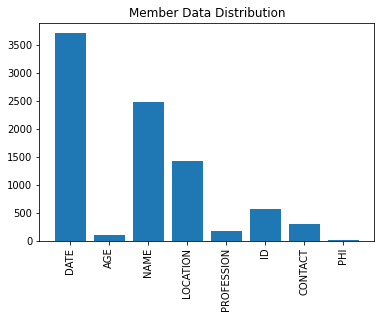

In [119]:
import matplotlib.pyplot as plt

x = range(len(member_data))
y = [member_data[ent][1] for ent in member_data]

plt.bar(x, y, align='center')
plt.xticks(x, list(member_data.keys()), rotation='vertical')
plt.title("Member Data Distribution")

Text(0.5, 1.0, 'Test Data Distribution')

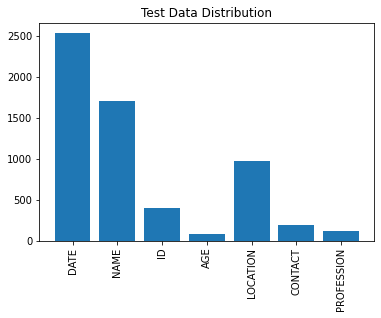

In [120]:
import matplotlib.pyplot as plt

x = range(len(non_member_data))
y = [non_member_data[ent][1] for ent in non_member_data]

plt.bar(x, y, align='center')
plt.xticks(x, list(non_member_data.keys()), rotation='vertical')
plt.title("Test Data Distribution")

In [121]:
diff_set = {}

for ent in member_data:
    if ent in non_member_data:
        member_list = member_data[ent][0]
        non_member_list = non_member_data[ent][0]
        common_list = list(set(member_list) & set(non_member_list))
        diff_list = list(set(non_member_list) - set(common_list))
        diff_set[ent] = (diff_list, len(diff_list))

Text(0.5, 1.0, 'Non-Member Data Distribution')

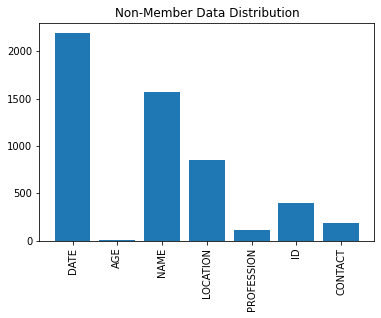

In [122]:
import matplotlib.pyplot as plt

x = range(len(diff_set))
y = [diff_set[ent][1] for ent in diff_set]

plt.bar(x, y, align='center')
plt.xticks(x, list(diff_set.keys()), rotation='vertical')
plt.title("Non-Member Data Distribution")

# TESTING

In [16]:
from collections import defaultdict
def get_token_start_and_end(tokens, secret, nlp):
    doc = nlp(secret)
    t = [str(token) for token in doc]
    indexes = [tokens.index(x) for x in t if x in tokens]
    print(secret, tokens[indexes[0]], tokens[indexes[-1]])
    return indexes[0], indexes[-1]+1

def get_scores_given_sentences_label(model=None, texts=None, ground_truth=None, TARGET_LABEL=None, beam_width=3):
    nlp = model

    grouth_truth_scores = []

    # Beam_width - Number of alternate analyses to consider. More is slower, and not necessarily better -- you need to experiment on your problem.
    # beam_density - This clips solutions at each step. We multiply the score of the top-ranked action by this value, and use the result as a threshold. This prevents the parser from exploring options that look very unlikely, saving a bit of efficiency. Accuracy may also improve, because we've trained on greedy objective.
    beam_density = 0.0001 

    ner = nlp.get_pipe('ner')

    for index in range(0, len(texts)):
        sentence = texts[index]
        print(sentence)
        doc = nlp.make_doc(sentence)
        beams = ner.beam_parse([doc], beam_width=beam_width, beam_density=beam_density)
        entity_scores = defaultdict(float)
        total_score = 0

        secret = ground_truth[index]
        print(secret)
        tokens = [str(token) for token in doc]
        #secret_index = get_secret_index(sentence, nlp, secret)

        secret_token_index, secret_token_end = get_token_start_and_end(tokens, secret, nlp)
        
        for score, ents in ner.moves.get_beam_parses(beams[0]):
            total_score += score
            for start, end, label in ents:
                entity_scores[(start, end, label)] += score
        #entities = [entity[2] for entity in entity_scores]
        if (secret_token_index,secret_token_end,TARGET_LABEL) not in entity_scores:
            entity_scores[(secret_token_index,secret_token_end,TARGET_LABEL)] = 0.0
        normalized_beam_score = {dict_key: dict_value/total_score for dict_key, dict_value in entity_scores.items()}

        grouth_truth_scores.append(normalized_beam_score[(secret_token_index,secret_token_end,TARGET_LABEL)])

        #print(normalized_beam_score[(secret_token_index,secret_token_end,TARGET_LABEL)], (secret_token_index,secret_token_end,TARGET_LABEL))

    return grouth_truth_scores

In [15]:
train_data_path = "dataset/i2b2_n2c2_train_data.pickle"
file = open(train_data_path, 'rb')
TRAIN_DATA = pickle.load(file)
print(len(TRAIN_DATA))


member_set_path = "dataset/i2b2_n2c2_CONTACT_member_sentences.pickle"
print(member_set_path.split(".")[0].replace("/", "_").split("_")[-3])
file = open(member_set_path, 'rb')
train_sentence_data = pickle.load(file)

#print([(sentence[0], sentence[1]) for sentence in train_sentence_data if sentence[1] == "LA"])
member_texts = [sentence[0] for sentence in train_sentence_data]
member_gt = [sentence[1] for sentence in train_sentence_data]

non_member_set_path = "dataset/i2b2_n2c2_CONTACT_non_member_sentences.pickle"
file = open(non_member_set_path, 'rb')
test_sentence_data = pickle.load(file)
non_member_texts = [sentence[0] for sentence in train_sentence_data]
non_member_gt = [sentence[1] for sentence in train_sentence_data]
print(set(member_gt), set(non_member_gt))
#print(set(member_gt) - set(non_member_gt))

LABEL = "LOCATION"
beam_width=3

785
CONTACT
{'(201) 957-6458', '155-900-5638', '75059', '516-532-0945', '99591', '95321', '659-5187', '64012', '03533', 'Web Services', '11591', '95540', '04239', '45811', '42390', '07747', '(033) 250-1408', '43903', '06885', '25347', '46002', '128-526-1384', '61158', '90859', '80817', '(838) 627-3027', '249-007-9762', '75197', '13828', '78686', '79915', '851-9764-289', '66553', '76228', '47980', '61303', '668-508-1062', '34596', '05396', '877-274-0509', '(615) 305-3068', '929-462-2794', '70849', '81895', 'vmeadows@sbhnc.org', '(056) 216-7457', '22148', '60809', '77198', '(779)226-7473', '66612', '23324', '18412', '69981', '(545) 266-9272', '534-184-9285', '99478', '74783', '39693', '12906', '02664', '51158', '(215)638-3640', 'gmichael@KCM.ORG', '(153) 636-7011', '00933', '485-914-7948', '5', '51363', '895.376.3157', '12182', '34348', '25329', '24104', '65261', '72884', '(468) 429-7459', '310-7911', '14338', '34318', '553 594-2217', '(783)508-2821', '26494', '155-837-6998', '23190', '0

In [20]:
get_scores_given_sentences_label(model=nlp, texts=member_texts, ground_truth=member_gt, TARGET_LABEL=LABEL, beam_width=beam_width)

   Saw Dr Oakley 4/5/67 - she was happy with results of ETT at Clarkfield .  To f/u 7/67 .  No CP's since last admit.
Clarkfield
Clarkfield Clarkfield Clarkfield
Coronary artery disease : s/p ant SEMI + stent LAD 2/67 , Dr Oakley , ETT Clarkfield 3/67 - neg scan for ischemia.
Clarkfield
Clarkfield Clarkfield Clarkfield
Coronary artery disease : s/p ant SEMI + stent LAD 2/67 , Dr Oakley , ETT Clarkfield 3/67 - neg scan for ischemia. No CP's, palp.  Saw Dr Oakley today.  Off plavix for the last several months which was what Dr Oakley intended.  She was "pleased" with everything.
Clarkfield
Clarkfield Clarkfield Clarkfield
Social History	working for Convergys as Sculptor , married, one son - 26 yo who lives with them.
Convergys
Convergys Convergys Convergys
Coronary artery disease : s/p ant SEMI + stent LAD 2/67 , Dr Oakley , ETT Clarkfield 3/67 - neg scan for ischemia. No CP's, palp. Not seen cardiology for two to 3 years. Will make follow-up with cardiology now that Dr Oakley gone
Clark

WETZEL COUNTY HOSPITAL
WETZEL COUNTY HOSPITAL WETZEL HOSPITAL
He hasbeen active physically and does a considerable amount of scuba diving in addition to his duties at Mason House
Mason House
Mason House Mason House
He was transferred in January 2083 to the WCH after presenting to the Florida Hospital Orlando with a non ST segment elevation MI in the anterolateral zone. He underwent angioplasty and stenting of his proximal LAD using a 2.5 x 13 mm Cypher drug eluting stent.
WCH
WCH WCH WCH
He was transferred in January 2083 to the WCH after presenting to the Florida Hospital Orlando with a non ST segment elevation MI in the anterolateral zone. He underwent angioplasty and stenting of his proximal LAD using a 2.5 x 13 mm Cypher drug eluting stent.
Florida Hospital Orlando
Florida Hospital Orlando Florida Orlando
He hasbeen active physically and does a considerable amount of scuba diving in addition to his duties at Mason House
Mason House
Mason House Mason House
	 WETZEL COUNTY HOSPITAL
W

Lagrange Lagrange Lagrange
   Lives with wife in Lagrange , KS . Retired. Former heavy smoker-quit x 30 yrs. Rare ETOH.
KS
KS KS KS
HIGHLAND HOSITAL VISIT
HIGHLAND HOSITAL
HIGHLAND HOSITAL HIGHLAND HOSITAL
SH: originally from Mt . Married for 39 years to Friedman , describes marriage as
Mt
Mt Mt Mt
hartsville and 1 in nuku'alofa . no pets. fulltime author . husband has h/p
hartsville
hartsville hartsville hartsville
hartsville and 1 in nuku'alofa . no pets. fulltime author . husband has h/p
nuku'alofa
nuku'alofa nuku'alofa nuku'alofa
Previously recommended starting BID dosing of lantus and adding 10 units in PM, but not able to obtain yet from pfizer ; discussed that for some individuals it dose not last for 24 hours adn that they get better glucose control w BID dosing. Discussed that she will likely need to decrease her PM dose of novolog
pfizer
pfizer pfizer pfizer
----discussed nutrition referral; pt declined but plans on joining south beach diet
south beach diet
south beach diet s

NORTHLAND MEDICAL CLINIC
NORTHLAND MEDICAL CLINIC NORTHLAND CLINIC
Followed at Christy Clinic for DM. On NPH 34 AM, 12 PM and regular 10 QM and 14PM. Last HBAIC 8.9 from 7.2.  Not on ACE due to cough. Did not tolerate ARB. Ophtho exam UTD. Continue current regimen for now and followup with Christy for insulin adjustments
Christy Clinic
Christy Clinic Christy Clinic
Followed at Christy Clinic for DM. On NPH 34 AM, 12 PM and regular 10 QM and 14PM. Last HBAIC 8.9 from 7.2.  Not on ACE due to cough. Did not tolerate ARB. Ophtho exam UTD. Continue current regimen for now and followup with Christy for insulin adjustments
Christy
Christy Christy Christy
s/p CABG x 3. On atenolol/ASA. In Fahey Center last week for CP (no change from previous) while exercising at cardiac rehab. Has had several stress tests after surgery that have been negative. Pt never started Imdur as directed. Will try this. 
Fahey Center
Fahey Center Fahey Center
NMC
NMC
NMC NMC NMC
NORTHLAND MEDICAL CLINIC
NORTHLAND MEDIC

IndexError: list index out of range

In [18]:
non_member_texts = [sentence[0] for sentence in test_id_sentences]
non_member_gt = [sentence[1] for sentence in test_id_sentences]

In [19]:
get_scores_given_sentences_label(model=nlp, texts=member_texts, ground_truth=member_gt, label=LABEL, beam_width=beam_width)

NameError: name 'get_scores_given_sentences_label' is not defined

In [207]:
len(train_id_sentences)

875

In [53]:
import numpy as np
ranks = [[1,2,3,4], [4,3,2,1], [5,6,7,8]]



[np.mean(np.array(t)) for t in list(zip(*ranks))]

[3.3333333333333335, 3.6666666666666665, 4.0, 4.333333333333333]

In [54]:
rankss=[]
for rank in ranks:
    rankss.append([r/2 for r in rank])


In [55]:
rankss

[[0.5, 1.0, 1.5, 2.0], [2.0, 1.5, 1.0, 0.5], [2.5, 3.0, 3.5, 4.0]]

In [16]:
avg_epoch_ner_score = []
ner_score = [[(1, 0.2573260073260073), (2, 0.3110202691194004), (3, 0.34081178283952734), (4, 0.3272608978529603)], [(1, 0.2573260073260073), (2, 0.3110202691194004), (3, 0.34081178283952734), (4, 0.3272608978529603)]]

In [24]:
list(zip(*ner_score))

[((1, 0.2573260073260073), (1, 0.2573260073260073)),
 ((2, 0.3110202691194004), (2, 0.3110202691194004)),
 ((3, 0.34081178283952734), (3, 0.34081178283952734)),
 ((4, 0.3272608978529603), (4, 0.3272608978529603))]

In [98]:
avg_epoch_losses = []
epoch_losses = [[(1, 12602.311254075714), (2, 11535.972930817523), (3, 11270.334286055364), (4, 11206.6639520538), (4, 11206.6639520538)], [(1, 12602.311254075714), (2, 11535.972930817523), (3, 11270.334286055364), (4, 11206.6639520538), (4, 11206.6639520538)]]

In [99]:
list(zip(*epoch_losses))

[((1, 12602.311254075714), (1, 12602.311254075714)),
 ((2, 11535.972930817523), (2, 11535.972930817523)),
 ((3, 11270.334286055364), (3, 11270.334286055364)),
 ((4, 11206.6639520538), (4, 11206.6639520538)),
 ((4, 11206.6639520538), (4, 11206.6639520538))]

In [103]:
zipped = list(zip(*epoch_losses))
avg_epoch_losses_per_sub_run = [np.mean(np.array(list(zip(*run))[1])) for run in zipped]
print(avg_epoch_losses_per_sub_run)
avg_epoch_losses.append(avg_epoch_losses_per_sub_run)

[12602.311254075714, 11535.972930817523, 11270.334286055364, 11206.6639520538, 11206.6639520538]


In [91]:
avg_epoch_losses

[[6301.655627037857,
  5768.986465408761,
  5636.667143027682,
  5605.3319760269,
  5605.3319760269]]

In [86]:
avg_epoch_losses = [np.mean(np.array(t)) for t in list(zip(*avg_epoch_losses))]

In [87]:
avg_epoch_losses

[6301.655627037857,
 5768.986465408761,
 5636.667143027682,
 5605.3319760269,
 5605.3319760269]

In [22]:
avg_gen_ner_score_sub_run = [np.mean(np.array(t)) for t in list(zip(*ner_score))]
avg_epoch_ner_score.append(avg_gen_ner_score_sub_run)

In [23]:
avg_gen_ner_score_sub_run

[0.6286630036630036,
 1.1555101345597003,
 1.6704058914197635,
 2.1636304489264804]

In [19]:
avg_epoch_ner_score

[[0.6286630036630036,
  1.1555101345597003,
  1.6704058914197635,
  2.1636304489264804]]

In [37]:
avg_epoch_ner_score = [np.mean(np.array(t)) for t in list(zip(*avg_epoch_ner_score))]

In [2]:
n = 100
while n<100000:
    print(n)
    n = n*2

100
200
400
800
1600
3200
6400
12800
25600
51200
